<a href="https://colab.research.google.com/github/banatehrani/Transformers-for-Natural-Language-Processing/blob/main/Tranformers1_HighLevel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The codes in this notebook have been borrowed from a course on Udemy named Transformers for Natural Language processing.

In [ ]:
!pip install transformers sentencepiece transformers[sentencepiece]

In [ ]:
from transformers import pipeline, set_seed

import pickle
import textwrap
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, confusion_matrix
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.tokenize import RegexpTokenizer

from pprint import pprint

### **Sentiment Analysis**

In [ ]:
# https://www.kaggle.com/crowdflower/twitter-airline-sentiment
!wget -nc https://lazyprogrammer.me/course_files/AirlineTweets.csv

--2023-10-26 01:30:40--  https://lazyprogrammer.me/course_files/AirlineTweets.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 104.21.23.210, 172.67.213.166, 2606:4700:3030::ac43:d5a6, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|104.21.23.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3421431 (3.3M) [text/csv]
Saving to: ‘AirlineTweets.csv’

AirlineTweets.csv   100%[===================>]   3.26M  1.19MB/s    in 2.7s    

2023-10-26 01:30:44 (1.19 MB/s) - ‘AirlineTweets.csv’ saved [3421431/3421431]



**Checking the basic binary classifier**

In [ ]:
# Basic usage
classifier = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [ ]:
type(classifier)

transformers.pipelines.text_classification.TextClassificationPipeline

In [ ]:
classifier("This is such a great movie!")

[{'label': 'POSITIVE', 'score': 0.9998759031295776}]

In [ ]:
classifier("This show was not interesting")

[{'label': 'NEGATIVE', 'score': 0.9997871518135071}]

In [ ]:
classifier("This show was interesting")

[{'label': 'POSITIVE', 'score': 0.999747097492218}]

In [ ]:
classifier("This show was not bad at all")

[{'label': 'POSITIVE', 'score': 0.998742401599884}]

In [ ]:
classifier("I can't say that this was a good movie")

[{'label': 'NEGATIVE', 'score': 0.9278441071510315}]

In [ ]:
# Multiple inputs passed in as a list
classifier([
  "This course is just what I needed.",
  "I can't understand any of this. Instructor kept telling me to meet the \
    prerequisites. What are prerequisites? Why does he keep saying that?"
])

[{'label': 'POSITIVE', 'score': 0.9991594552993774},
 {'label': 'NEGATIVE', 'score': 0.9966675639152527}]

**Using GPU**

In [ ]:
import torch

In [ ]:
torch.cuda.is_available()

True

In [ ]:
torch.cuda.current_device()

0

In [ ]:
# Use the GPU
classifier = pipeline("sentiment-analysis", device=0)

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


**Data cleaning for binary classification**

In [ ]:
df_ = pd.read_csv("AirlineTweets.csv")

In [ ]:
df_.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [ ]:
df = df_[['airline_sentiment', 'text']].copy()

<Axes: >

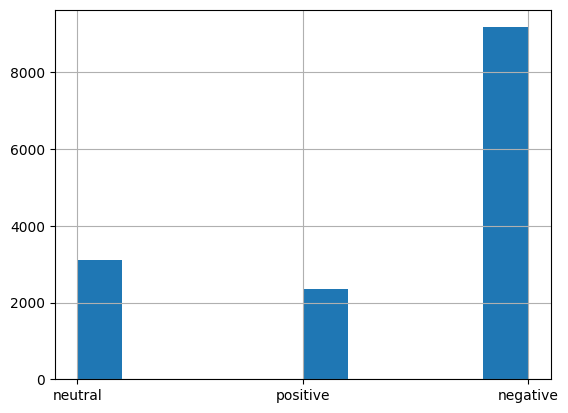

In [ ]:
# Three classes and the imbalance between positive and negative can be seen
df['airline_sentiment'].hist()

In [ ]:
df = df[df.airline_sentiment != "neutral"].copy()

In [ ]:
target_map = {'positive':1, 'negative':0}
df['target'] = df['airline_sentiment'].map(target_map)

In [ ]:
df.head()

,airline_sentiment,text,target
1,positive,@VirginAmerica plus you've added commercials t...,1
3,negative,@VirginAmerica it's really aggressive to blast...,0
4,negative,@VirginAmerica and it's a really big bad thing...,0
5,negative,@VirginAmerica seriously would pay $30 a fligh...,0
6,positive,"@VirginAmerica yes, nearly every time I fly VX...",1


In [ ]:
len(df)

11541

In [ ]:
texts = df['text'].tolist()
predictions = classifier(texts)

In [ ]:
predictions[0:5]

[{'label': 'POSITIVE', 'score': 0.6070823669433594},
 {'label': 'NEGATIVE', 'score': 0.9973449110984802},
 {'label': 'NEGATIVE', 'score': 0.9995823502540588},
 {'label': 'NEGATIVE', 'score': 0.9854250550270081},
 {'label': 'POSITIVE', 'score': 0.9553212523460388}]

In [ ]:
# Probabilities for the positive class
probs = [d['score'] if d['label'].startswith('P') else 1-d['score'] \
         for d in predictions]

In [ ]:
probs[0:5]

[0.6070823669433594,
 0.0026550889015197754,
 0.0004176497459411621,
 0.014574944972991943,
 0.9553212523460388]

In [ ]:
preds = [1 if d['label'].startswith('P') else 0 for d in predictions]

In [ ]:
preds = np.array(preds)

In [ ]:
print("acc: ", np.mean(df['target']==preds))

acc:  0.8898708950697514


In [ ]:
cm = confusion_matrix(df['target'], preds, normalize='true')
cm

array([[0.90117673, 0.09882327],
       [0.15404147, 0.84595853]])

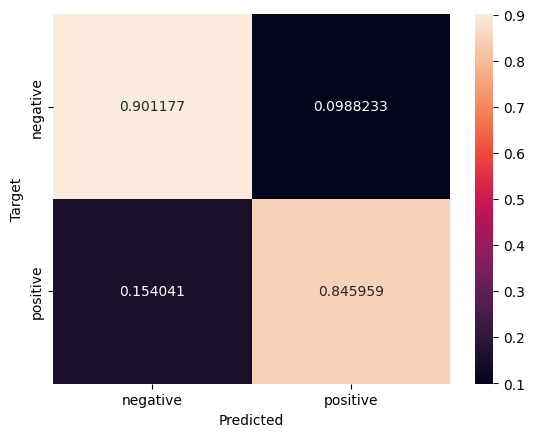

In [ ]:
# Scikit-Learn is transitioning to V1 but it's not available on Colab
# The changes modify how confusion matrices are plotted
def plot_cm(cm):
  classes = ['negative', 'positive']
  df_cm = pd.DataFrame(cm, index=classes, columns=classes)
  ax = sn.heatmap(df_cm, annot=True, fmt='g')
  ax.set_xlabel("Predicted")
  ax.set_ylabel("Target")

plot_cm(cm)

In [ ]:
f1_score(df['target'], preds)

0.7587777566900741

In [ ]:
# Sensitive to the meaning of labels
f1_score(1-df['target'], 1-preds)

0.928647616908999

In [ ]:
# Not sensitive to the meaning of labels
roc_auc_score(df['target'], probs)

0.9485933999009757

In [ ]:
roc_auc_score(1 - df['target'], 1 - np.array(probs))

0.9485933999009756

### **Text Generation**

In [ ]:
!wget -nc https://raw.githubusercontent.com/lazyprogrammer/machine_learning_examples/master/hmm_class/robert_frost.txt

--2023-10-26 01:32:30--  https://raw.githubusercontent.com/lazyprogrammer/machine_learning_examples/master/hmm_class/robert_frost.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 56286 (55K) [text/plain]
Saving to: ‘robert_frost.txt’

robert_frost.txt    100%[===================>]  54.97K  --.-KB/s    in 0.001s  

2023-10-26 01:32:30 (39.9 MB/s) - ‘robert_frost.txt’ saved [56286/56286]



In [ ]:
!cat robert_frost.txt

Two roads diverged in a yellow wood,
And sorry I could not travel both
And be one traveler, long I stood
And looked down one as far as I could
To where it bent in the undergrowth; 

Then took the other, as just as fair,
And having perhaps the better claim
Because it was grassy and wanted wear,
Though as for that the passing there
Had worn them really about the same,

And both that morning equally lay
In leaves no step had trodden black.
Oh, I kept the first for another day! 
Yet knowing how way leads on to way
I doubted if I should ever come back.

I shall be telling this with a sigh
Somewhere ages and ages hence:
Two roads diverged in a wood, and I,
I took the one less traveled by,
And that has made all the difference.

Whose woods these are I think I know.
His house is in the village, though; 
He will not see me stopping here
To watch his woods fill up with snow.

My little horse must think it queer
To stop without a farmhouse near
Between the woods and frozen lake
The darkest evenin

In [ ]:
lines = [line.rstrip() for line in open('robert_frost.txt')]
lines = [line for line in lines if len(line) > 0]

In [ ]:
gen = pipeline("text-generation")

No model was supplied, defaulted to gpt2 and revision 6c0e608 (https://huggingface.co/gpt2).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [ ]:
set_seed(1234)

In [ ]:
lines[0]

'Two roads diverged in a yellow wood,'

In [ ]:
gen(lines[0])

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[{'generated_text': 'Two roads diverged in a yellow wood, which they had left behind a few yards from where they had cut from. At the end of the road stood a tall red pole and, just out of view, the white-lipped man could see'}]

In [ ]:
pprint(_)

[{'generated_text': 'Two roads diverged in a yellow wood, which they had left '
                    'behind a few yards from where they had cut from. At the '
                    'end of the road stood a tall red pole and, just out of '
                    'view, the white-lipped man could see'}]


In [ ]:
pprint(gen(lines[0], max_length=20))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[{'generated_text': 'Two roads diverged in a yellow wood, and each turned into '
                    'a narrow black hole. It became'}]


In [ ]:
pprint(gen(lines[0], num_return_sequences=3, max_length=20))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[{'generated_text': 'Two roads diverged in a yellow wood, about 200 yards from '
                    'the beach.\n'
                    '\n'
                    'Then she'},
 {'generated_text': 'Two roads diverged in a yellow wood, just across from a '
                    'house and a park.\n'
                    '\n'},
 {'generated_text': 'Two roads diverged in a yellow wood, with a '
                    'black-and-white line running west to'}]


In [ ]:
def wrap(x):
  return textwrap.fill(x, replace_whitespace=False, fix_sentence_endings=True)

In [ ]:
out = gen(lines[0], max_length=30)
print(wrap(out[0]['generated_text']))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Two roads diverged in a yellow wood, which was called the A-track, and
three separate roads converged in the north and in the south


In [ ]:
prev = 'Two roads diverged in a yellow wood, which turned out to be a small,' + \
  ' narrow road that runs along a portion of the road.'

out = gen(prev + '\n' + lines[2], max_length=60)
print(wrap(out[0]['generated_text']))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Two roads diverged in a yellow wood, which turned out to be a small,
narrow road that runs along a portion of the road.
And be one
traveler, long I stood.  As I stood there, thinking, "I am certain of
my friend, that I was sure of that gentleman


In [ ]:
prev = 'Two roads diverged in a yellow wood, which turned out to be a small,' + \
  ' narrow road that runs along a portion of the road.\n' + \
  'And be one traveler, long I stood in line, the road was one of long, ' + \
  'clear, yellow road. Yet there stood the road.'

out = gen(prev + '\n' + lines[4], max_length=90)
print(wrap(out[0]['generated_text']))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Two roads diverged in a yellow wood, which turned out to be a small,
narrow road that runs along a portion of the road.
And be one
traveler, long I stood in line, the road was one of long, clear,
yellow road.  Yet there stood the road.
To where it bent in the
undergrowth; where it was made of the snow and hard soil of the soil
of the place where I stood; which had


In [ ]:
prompt = "Neural networks with attention have been used with great success"  + \
  " in natural language processing."
out = gen(prompt, max_length=300)
print(wrap(out[0]['generated_text']))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Neural networks with attention have been used with great success in
natural language processing.  However, some studies in animal studies
have focused purely on a single channel, and only the information from
a given language has been reported before.  The present work is aimed
at investigating such connections between language processing in
humans and other animal brain networks and their connectivity during
processing and reclassification during translation.  By working in a
highly specific temporal domain of the human left prefrontal cortex
and comparing it with the language of the animal left amygdala, we
explored the effect of bilingualness on recognition and word
association.  In fact, we have observed a significant amount of
bilingualization in translation.  In contrast to the bilinguality
observed for a similar linguistic and non-bilingual social network,
the interaction between the language of the left amygdala and the
language of the right hemisphere is more complex: bilingua

### **Masked Language Modelling (Article Spinner)**

In [ ]:
# https://www.kaggle.com/shivamkushwaha/bbc-full-text-document-classification
!wget -nc https://lazyprogrammer.me/course_files/nlp/bbc_text_cls.csv

--2023-10-26 01:33:02--  https://lazyprogrammer.me/course_files/nlp/bbc_text_cls.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 172.67.213.166, 104.21.23.210, 2606:4700:3031::6815:17d2, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|172.67.213.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5085081 (4.8M) [text/csv]
Saving to: ‘bbc_text_cls.csv’

bbc_text_cls.csv    100%[===================>]   4.85M  1.14MB/s    in 5.1s    

2023-10-26 01:33:09 (971 KB/s) - ‘bbc_text_cls.csv’ saved [5085081/5085081]



In [ ]:
df = pd.read_csv('bbc_text_cls.csv')

In [ ]:
df.head()

,text,labels
0,Ad sales boost Time Warner profit\n\nQuarterly...,business
1,Dollar gains on Greenspan speech\n\nThe dollar...,business
2,Yukos unit buyer faces loan claim\n\nThe owner...,business
3,High fuel prices hit BA's profits\n\nBritish A...,business
4,Pernod takeover talk lifts Domecq\n\nShares in...,business


In [ ]:
labels = set(df['labels'])
labels

{'business', 'entertainment', 'politics', 'sport', 'tech'}

In [ ]:
# Pick a label
label = 'business'

In [ ]:
texts = df[df['labels']==label]['text']
texts.head()

0    Ad sales boost Time Warner profit\n\nQuarterly...
1    Dollar gains on Greenspan speech\n\nThe dollar...
2    Yukos unit buyer faces loan claim\n\nThe owner...
3    High fuel prices hit BA's profits\n\nBritish A...
4    Pernod takeover talk lifts Domecq\n\nShares in...
Name: text, dtype: object

In [ ]:
np.random.seed(1234)

In [ ]:
i = np.random.choice(texts.shape[0])
doc = texts.iloc[i]

In [ ]:
print(textwrap.fill(doc, replace_whitespace=False, fix_sentence_endings=True))

Bombardier chief to leave company

Shares in train and plane-making
giant Bombardier have fallen to a 10-year low following the departure
of its chief executive and two members of the board.

Paul Tellier,
who was also Bombardier's president, left the company amid an ongoing
restructuring.  Laurent Beaudoin, part of the family that controls the
Montreal-based firm, will take on the role of CEO under a newly
created management structure.  Analysts said the resignations seem to
have stemmed from a boardroom dispute.  Under Mr Tellier's tenure at
the company, which began in January 2003, plans to cut the worldwide
workforce of 75,000 by almost a third by 2006 were announced.  The
firm's snowmobile division and defence services unit were also sold
and Bombardier started the development of a new aircraft seating 110
to 135 passengers.

Mr Tellier had indicated he wanted to stay at the
world's top train maker and third largest manufacturer of civil
aircraft until the restructuring was comple

In [ ]:
mlm = pipeline('fill-mask')

No model was supplied, defaulted to distilroberta-base and revision ec58a5b (https://huggingface.co/distilroberta-base).
Using a pipeline without specifying a model name and revision in production is not recommended.


Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaForMaskedLM: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
mlm('Bombardier chief to leave <mask>')

[{'score': 0.06950785219669342,
  'token': 633,
  'token_str': ' job',
  'sequence': 'Bombardier chief to leave job'},
 {'score': 0.0669308453798294,
  'token': 1470,
  'token_str': ' France',
  'sequence': 'Bombardier chief to leave France'},
 {'score': 0.05273520573973656,
  'token': 558,
  'token_str': ' office',
  'sequence': 'Bombardier chief to leave office'},
 {'score': 0.025823047384619713,
  'token': 2201,
  'token_str': ' Paris',
  'sequence': 'Bombardier chief to leave Paris'},
 {'score': 0.021368566900491714,
  'token': 896,
  'token_str': ' Canada',
  'sequence': 'Bombardier chief to leave Canada'}]

In [ ]:
text = 'Shares in <mask> and plane-making ' + \
  'giant Bombardier have fallen to a 10-year low following the departure ' + \
  'of its chief executive and two members of the board.'

mlm(text)

[{'score': 0.6640956401824951,
  'token': 11016,
  'token_str': ' Airbus',
  'sequence': 'Shares in Airbus and plane-making giant Bombardier have fallen to a 10-year low following the departure of its chief executive and two members of the board.'},
 {'score': 0.2614656686782837,
  'token': 6722,
  'token_str': ' Boeing',
  'sequence': 'Shares in Boeing and plane-making giant Bombardier have fallen to a 10-year low following the departure of its chief executive and two members of the board.'},
 {'score': 0.023635322228074074,
  'token': 15064,
  'token_str': ' aerospace',
  'sequence': 'Shares in aerospace and plane-making giant Bombardier have fallen to a 10-year low following the departure of its chief executive and two members of the board.'},
 {'score': 0.01458178460597992,
  'token': 8537,
  'token_str': ' airlines',
  'sequence': 'Shares in airlines and plane-making giant Bombardier have fallen to a 10-year low following the departure of its chief executive and two members of the

In [ ]:
text = 'Shares in train and plane-making ' + \
  'giant Bombardier have fallen to a 10-year low following the <mask> ' + \
  'of its chief executive and two members of the board.'

pprint(mlm(text))

[{'score': 0.5513914823532104,
  'sequence': 'Shares in train and plane-making giant Bombardier have fallen '
              'to a 10-year low following the resignation of its chief '
              'executive and two members of the board.',
  'token': 6985,
  'token_str': ' resignation'},
 {'score': 0.21090511977672577,
  'sequence': 'Shares in train and plane-making giant Bombardier have fallen '
              'to a 10-year low following the departure of its chief executive '
              'and two members of the board.',
  'token': 5824,
  'token_str': ' departure'},
 {'score': 0.1304200440645218,
  'sequence': 'Shares in train and plane-making giant Bombardier have fallen '
              'to a 10-year low following the departures of its chief '
              'executive and two members of the board.',
  'token': 25624,
  'token_str': ' departures'},
 {'score': 0.03651570528745651,
  'sequence': 'Shares in train and plane-making giant Bombardier have fallen '
              'to a 10-yea

In [ ]:
text = 'Shares in train and plane-making ' + \
  'giant Bombardier have fallen to a 10-year low following the departure ' + \
  'of its chief <mask> and two members of the board.'

pprint(mlm(text))

[{'score': 0.9897111058235168,
  'sequence': 'Shares in train and plane-making giant Bombardier have fallen '
              'to a 10-year low following the departure of its chief executive '
              'and two members of the board.',
  'token': 1031,
  'token_str': ' executive'},
 {'score': 0.006391047965735197,
  'sequence': 'Shares in train and plane-making giant Bombardier have fallen '
              'to a 10-year low following the departure of its chief '
              'executives and two members of the board.',
  'token': 4585,
  'token_str': ' executives'},
 {'score': 0.0016239372780546546,
  'sequence': 'Shares in train and plane-making giant Bombardier have fallen '
              'to a 10-year low following the departure of its chief economist '
              'and two members of the board.',
  'token': 7473,
  'token_str': ' economist'},
 {'score': 0.0007142710965126753,
  'sequence': 'Shares in train and plane-making giant Bombardier have fallen '
              'to a 10-ye

In [ ]:
text = 'Shares in train and plane-making ' + \
  'giant Bombardier have fallen to a 10-year low following the departure ' + \
  'of its chief executive and two <mask> of the board.'

pprint(mlm(text))

[{'score': 0.942054271697998,
  'sequence': 'Shares in train and plane-making giant Bombardier have fallen '
              'to a 10-year low following the departure of its chief executive '
              'and two members of the board.',
  'token': 453,
  'token_str': ' members'},
 {'score': 0.032231759279966354,
  'sequence': 'Shares in train and plane-making giant Bombardier have fallen '
              'to a 10-year low following the departure of its chief executive '
              'and two thirds of the board.',
  'token': 29193,
  'token_str': ' thirds'},
 {'score': 0.011232937686145306,
  'sequence': 'Shares in train and plane-making giant Bombardier have fallen '
              'to a 10-year low following the departure of its chief executive '
              'and two directors of the board.',
  'token': 5392,
  'token_str': ' directors'},
 {'score': 0.003028053790330887,
  'sequence': 'Shares in train and plane-making giant Bombardier have fallen '
              'to a 10-year low fo

### **Named Entity Recognition (NER)**

In [ ]:
ner = pipeline("ner", aggregation_strategy='simple', device=0)

No model was supplied, defaulted to dbmdz/bert-large-cased-finetuned-conll03-english and revision f2482bf (https://huggingface.co/dbmdz/bert-large-cased-finetuned-conll03-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
# conll 2003
!wget -nc https://lazyprogrammer.me/course_files/nlp/ner_train.pkl
!wget -nc https://lazyprogrammer.me/course_files/nlp/ner_test.pkl

--2023-10-26 01:33:32--  https://lazyprogrammer.me/course_files/nlp/ner_train.pkl
Resolving lazyprogrammer.me (lazyprogrammer.me)... 172.67.213.166, 104.21.23.210, 2606:4700:3031::6815:17d2, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|172.67.213.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4757208 (4.5M) [application/octet-stream]
Saving to: ‘ner_train.pkl’

ner_train.pkl       100%[===================>]   4.54M  1.29MB/s    in 3.5s    

2023-10-26 01:33:36 (1.29 MB/s) - ‘ner_train.pkl’ saved [4757208/4757208]

--2023-10-26 01:33:37--  https://lazyprogrammer.me/course_files/nlp/ner_test.pkl
Resolving lazyprogrammer.me (lazyprogrammer.me)... 172.67.213.166, 104.21.23.210, 2606:4700:3030::ac43:d5a6, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|172.67.213.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1201978 (1.1M) [application/octet-stream]
Saving to: ‘ner_test.pkl’

ner_test.pkl        100%[=========

In [ ]:
with open('ner_train.pkl', 'rb') as f:
  corpus_train = pickle.load(f)

with open('ner_test.pkl', 'rb') as f:
  corpus_test = pickle.load(f)

In [ ]:
corpus_test

[[('CRICKET', 'O'),
  ('-', 'O'),
  ('LEICESTERSHIRE', 'B-ORG'),
  ('TAKE', 'O'),
  ('OVER', 'O'),
  ('AT', 'O'),
  ('TOP', 'O'),
  ('AFTER', 'O'),
  ('INNINGS', 'O'),
  ('VICTORY', 'O'),
  ('.', 'O')],
 [('West', 'B-MISC'),
  ('Indian', 'I-MISC'),
  ('all-rounder', 'O'),
  ('Phil', 'B-PER'),
  ('Simmons', 'I-PER'),
  ('took', 'O'),
  ('four', 'O'),
  ('for', 'O'),
  ('38', 'O'),
  ('on', 'O'),
  ('Friday', 'O'),
  ('as', 'O'),
  ('Leicestershire', 'B-ORG'),
  ('beat', 'O'),
  ('Somerset', 'B-ORG'),
  ('by', 'O'),
  ('an', 'O'),
  ('innings', 'O'),
  ('and', 'O'),
  ('39', 'O'),
  ('runs', 'O'),
  ('in', 'O'),
  ('two', 'O'),
  ('days', 'O'),
  ('to', 'O'),
  ('take', 'O'),
  ('over', 'O'),
  ('at', 'O'),
  ('the', 'O'),
  ('head', 'O'),
  ('of', 'O'),
  ('the', 'O'),
  ('county', 'O'),
  ('championship', 'O'),
  ('.', 'O')],
 [('Their', 'O'),
  ('stay', 'O'),
  ('on', 'O'),
  ('top', 'O'),
  (',', 'O'),
  ('though', 'O'),
  (',', 'O'),
  ('may', 'O'),
  ('be', 'O'),
  ('short-lived', 

In [ ]:
inputs = []
targets = []

for sentence_tag_pairs in corpus_test:
  tokens = []
  target = []
  for token, tag in sentence_tag_pairs:
    tokens.append(token)
    target.append(tag)
  inputs.append(tokens)
  targets.append(target)

In [ ]:
inputs[9]

['He',
 'was',
 'well',
 'backed',
 'by',
 'England',
 'hopeful',
 'Mark',
 'Butcher',
 'who',
 'made',
 '70',
 'as',
 'Surrey',
 'closed',
 'on',
 '429',
 'for',
 'seven',
 ',',
 'a',
 'lead',
 'of',
 '234',
 '.']

In [ ]:
from nltk.tokenize.treebank import TreebankWordDetokenizer
detokenizer = TreebankWordDetokenizer()

In [ ]:
detokenizer.detokenize(inputs[9])

'He was well backed by England hopeful Mark Butcher who made 70 as Surrey closed on 429 for seven, a lead of 234.'

In [ ]:
targets[9]

['O',
 'O',
 'O',
 'O',
 'O',
 'B-LOC',
 'O',
 'B-PER',
 'I-PER',
 'O',
 'O',
 'O',
 'O',
 'B-ORG',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O']

In [ ]:
ner(detokenizer.detokenize(inputs[9]))

[{'entity_group': 'LOC',
  'score': 0.99967515,
  'word': 'England',
  'start': 22,
  'end': 29},
 {'entity_group': 'PER',
  'score': 0.99974275,
  'word': 'Mark Butcher',
  'start': 38,
  'end': 50},
 {'entity_group': 'ORG',
  'score': 0.9996264,
  'word': 'Surrey',
  'start': 66,
  'end': 72}]

In [ ]:
def compute_prediction(tokens, input_, ner_result):
  # map hugging face ner result to list of tags for later performance assessment
  # tokens is the original tokenized sentence
  # input_ is the detokenized string

  predicted_tags = []
  state = 'O' # keep track of state, so if O --> B, if B --> I, if I --> I
  current_index = 0
  for token in tokens:
    # find the token in the input_ (should be at or near the start)
    index = input_.find(token)
    assert(index >= 0)
    current_index += index # where we are currently pointing to

    # print(token, current_index) # debug

    # check if this index belongs to an entity and assign label
    tag = 'O'
    for entity in ner_result:
      if current_index >= entity['start'] and current_index < entity['end']:
        # then this token belongs to an entity
        if state == 'O':
          state = 'B'
        else:
          state = 'I'
        tag = f"{state}-{entity['entity_group']}"
        break
    if tag == 'O':
      # reset the state
      state = 'O'
    predicted_tags.append(tag)

    # remove the token from input_
    input_ = input_[index + len(token):]

    # update current_index
    current_index += len(token)

  # sanity check
  # print("len(predicted_tags)", len(predicted_tags))
  # print("len(tokens)", len(tokens))
  assert(len(predicted_tags) == len(tokens))
  return predicted_tags

In [ ]:
input_ = detokenizer.detokenize(inputs[9])
ner_result = ner(input_)
ptags = compute_prediction(inputs[9], input_, ner_result)

In [ ]:
accuracy_score(targets[9], ptags)

1.0

In [ ]:
for targ, pred in zip(targets[9], ptags):
  print(targ, pred)

O O
O O
O O
O O
O O
B-LOC B-LOC
O O
B-PER B-PER
I-PER I-PER
O O
O O
O O
O O
B-ORG B-ORG
O O
O O
O O
O O
O O
O O
O O
O O
O O
O O
O O


In [ ]:
# get detokenized inputs to pass into ner model
detok_inputs = []
for tokens in inputs:
  text = detokenizer.detokenize(tokens)
  detok_inputs.append(text)

In [ ]:
# 17 min on CPU, 3 min on GPU
ner_results = ner(detok_inputs)

In [ ]:
predictions = []
for tokens, text, ner_result in zip(inputs, detok_inputs, ner_results):
  pred = compute_prediction(tokens, text, ner_result)
  predictions.append(pred)

In [ ]:
# https://stackoverflow.com/questions/11264684/flatten-list-of-lists
def flatten(list_of_lists):
  flattened = [val for sublist in list_of_lists for val in sublist]
  return flattened

In [ ]:
# flatten targets and predictions
flat_predictions = flatten(predictions)
flat_targets = flatten(targets)

In [ ]:
accuracy_score(flat_targets, flat_predictions)

0.9916563354782848

In [ ]:
f1_score(flat_targets, flat_predictions, average='macro')

0.95403328229255

### **Text Summarization**

In [ ]:
# https://www.kaggle.com/shivamkushwaha/bbc-full-text-document-classification
!wget -nc https://lazyprogrammer.me/course_files/nlp/bbc_text_cls.csv

File ‘bbc_text_cls.csv’ already there; not retrieving.



In [ ]:
df = pd.read_csv('bbc_text_cls.csv')

In [ ]:
df.head()

,text,labels
0,Ad sales boost Time Warner profit\n\nQuarterly...,business
1,Dollar gains on Greenspan speech\n\nThe dollar...,business
2,Yukos unit buyer faces loan claim\n\nThe owner...,business
3,High fuel prices hit BA's profits\n\nBritish A...,business
4,Pernod takeover talk lifts Domecq\n\nShares in...,business


In [ ]:
doc = df[df.labels == 'business']['text'].sample(random_state=42)

In [ ]:
print(wrap(doc.iloc[0]))

Christmas sales worst since 1981

UK retail sales fell in December,
failing to meet expectations and making it by some counts the worst
Christmas since 1981.

Retail sales dropped by 1% on the month in
December, after a 0.6% rise in November, the Office for National
Statistics (ONS) said.  The ONS revised the annual 2004 rate of growth
down from the 5.9% estimated in November to 3.2%. A number of
retailers have already reported poor figures for December.  Clothing
retailers and non-specialist stores were the worst hit with only
internet retailers showing any significant growth, according to the
ONS.

The last time retailers endured a tougher Christmas was 23 years
previously, when sales plunged 1.7%.

The ONS echoed an earlier
caution from Bank of England governor Mervyn King not to read too much
into the poor December figures.  Some analysts put a positive gloss on
the figures, pointing out that the non-seasonally-adjusted figures
showed a performance comparable with 2003. The Novembe

In [ ]:
summarizer = pipeline("summarization")

No model was supplied, defaulted to sshleifer/distilbart-cnn-12-6 and revision a4f8f3e (https://huggingface.co/sshleifer/distilbart-cnn-12-6).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [ ]:
# To avoid passing title
summarizer(doc.iloc[0].split("\n", 1)[1])

[{'summary_text': ' Retail sales dropped by 1% on the month in December, after a 0.6% rise in November . Clothing retailers and non-specialist stores were the worst hit with only internet retailers showing any significant growth . The last time retailers endured a tougher Christmas was 23 years ago, when sales plunged 1.7% .'}]

In [ ]:
def print_summary(doc):
  result = summarizer(doc.iloc[0].split("\n", 1)[1])
  print(wrap(result[0]['summary_text']))

In [ ]:
print_summary(doc)

 Retail sales dropped by 1% on the month in December, after a 0.6%
rise in November . Clothing retailers and non-specialist stores were
the worst hit with only internet retailers showing any significant
growth . The last time retailers endured a tougher Christmas was 23
years ago, when sales plunged 1.7% .


In [ ]:
doc = df[df.labels == 'entertainment']['text'].sample(random_state=123)
print(wrap(doc.iloc[0]))

Goodrem wins top female MTV prize

Pop singer Delta Goodrem has
scooped one of the top individual prizes at the first Australian MTV
Music Awards.

The 21-year-old singer won the award for best female
artist, with Australian Idol runner-up Shannon Noll taking the title
of best male at the ceremony.  Goodrem, known in both Britain and
Australia for her role as Nina Tucker in TV soap Neighbours, also
performed a duet with boyfriend Brian McFadden.  Other winners
included Green Day, voted best group, and the Black Eyed Peas.
Goodrem, Green Day and the Black Eyed Peas took home two awards each.
As well as best female, Goodrem also took home the Pepsi Viewers
Choice Award, whilst Green Day bagged the prize for best rock video
for American Idiot.  The Black Eyed Peas won awards for best R 'n' B
video and sexiest video, both for Hey Mama.  Local singer and
songwriter Missy Higgins took the title of breakthrough artist of the
year, with Australian Idol winner Guy Sebastian taking the honours f

In [ ]:
print_summary(doc)

 The 21-year-old singer won the award for best female artist .
Australian Idol runner-up Shannon Noll took the title of best male at
the ceremony . Other winners included Green Day, the Black Eyed Peas,
Missy Higgins and Green Day . The VH1 First Music Award went to Cher
honouring her achievements within the music industry .


### **Neural Machine Translation**

In [ ]:
!wget -nc http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip

--2023-10-26 01:35:39--  http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.68.207, 64.233.170.207, 142.251.175.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.68.207|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2638744 (2.5M) [application/zip]
Saving to: ‘spa-eng.zip’

spa-eng.zip         100%[===================>]   2.52M  2.12MB/s    in 1.2s    

2023-10-26 01:35:40 (2.12 MB/s) - ‘spa-eng.zip’ saved [2638744/2638744]



In [ ]:
!unzip -nq spa-eng.zip

In [ ]:
!ls

AirlineTweets.csv  ner_test.pkl   robert_frost.txt  spa-eng
bbc_text_cls.csv   ner_train.pkl  sample_data	    spa-eng.zip


In [ ]:
ls spa-eng

_about.txt  spa.txt


In [ ]:
!head spa-eng/spa.txt

Go.	Ve.
Go.	Vete.
Go.	Vaya.
Go.	Váyase.
Hi.	Hola.
Run!	¡Corre!
Run.	Corred.
Who?	¿Quién?
Fire!	¡Fuego!
Fire!	¡Incendio!


In [ ]:
# compile eng-spa translations
eng2spa = {}
for line in open('spa-eng/spa.txt'):
  line = line.rstrip()
  eng, spa = line.split("\t")
  if eng not in eng2spa:
    eng2spa[eng] = []
  eng2spa[eng].append(spa)

In [ ]:
eng2spa

{'Go.': ['Ve.', 'Vete.', 'Vaya.', 'Váyase.'],
 'Hi.': ['Hola.'],
 'Run!': ['¡Corre!'],
 'Run.': ['Corred.'],
 'Who?': ['¿Quién?'],
 'Fire!': ['¡Fuego!', '¡Incendio!', '¡Disparad!'],
 'Help!': ['¡Ayuda!', '¡Socorro! ¡Auxilio!', '¡Auxilio!'],
 'Jump!': ['¡Salta!'],
 'Jump.': ['Salte.'],
 'Stop!': ['¡Parad!', '¡Para!', '¡Pare!'],
 'Wait!': ['¡Espera!'],
 'Wait.': ['Esperen.'],
 'Go on.': ['Continúa.', 'Continúe.'],
 'Hello!': ['Hola.'],
 'I ran.': ['Corrí.', 'Corría.'],
 'I try.': ['Lo intento.'],
 'I won!': ['¡He ganado!'],
 'Oh no!': ['¡Oh, no!'],
 'Relax.': ['Tomátelo con soda.'],
 'Smile.': ['Sonríe.'],
 'Attack!': ['¡Al ataque!', '¡Atacad!'],
 'Get up.': ['Levanta.'],
 'Go now.': ['Ve ahora mismo.'],
 'Got it!': ['¡Lo tengo!'],
 'Got it?': ['¿Lo pillas?', '¿Entendiste?'],
 'He ran.': ['Él corrió.'],
 'Hop in.': ['Métete adentro.'],
 'Hug me.': ['Abrázame.'],
 'I fell.': ['Me caí.'],
 'I know.': ['Yo lo sé.'],
 'I left.': ['Salí.'],
 'I lied.': ['Mentí.'],
 'I lost.': ['Perdí.'],
 'I 

In [ ]:
tokenizer = RegexpTokenizer(r'\w+')

In [ ]:
tokenizer.tokenize('¿Qué me cuentas?'.lower())

['qué', 'me', 'cuentas']

In [ ]:
tokens = tokenizer.tokenize('¿Qué me cuentas?'.lower())
# sentence_bleu([tokens], tokens) didn't give 1
sentence_bleu([tokens], tokens, weights=(1/3, 1/3, 1/3))

1.0

In [ ]:
# sentence_bleu([['hi']], ['hi']) didn't produce 1
sentence_bleu([['hi']], ['hi'], weights=(1, 0))

/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


1.0

In [ ]:
smoother = SmoothingFunction()
sentence_bleu(['hi'], 'hi', smoothing_function=smoother.method4)

0.2213885886251307

In [ ]:
# sentence_bleu(['hi there'.split()], 'hi there'.split()) did not produce 1
sentence_bleu(['hi there'.split()], 'hi there'.split(), weights=(1/2, 1/2))

1.0

In [ ]:
# sentence_bleu(['hi there friend'.split()], 'hi there friend'.split()) did not produce 1
sentence_bleu(['hi there friend'.split()], 'hi there friend'.split(), weights=(1/3, 1/3, 1/3))

1.0

In [ ]:
sentence_bleu([[1,2,3,4]], [1,2,3,4])

1.0

In [ ]:
eng2spa_tokens = {}
for eng, spa_list in eng2spa.items():
  spa_list_tokens = []
  for text in spa_list:
    tokens = tokenizer.tokenize(text.lower())
    spa_list_tokens.append(tokens)
  eng2spa_tokens[eng] = spa_list_tokens

In [ ]:
translator = pipeline("translation", model='Helsinki-NLP/opus-mt-en-es', device=0)

/usr/local/lib/python3.10/dist-packages/transformers/models/marian/tokenization_marian.py:197: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


In [ ]:
translator("I like eggs and ham")

[{'translation_text': 'Me gustan los huevos y el jamón.'}]

In [ ]:
eng_phrases = list(eng2spa.keys())
len(eng_phrases)

102904

In [ ]:
eng_phrases_subset = eng_phrases[20_000:21_000]

In [ ]:
# 27 min for 10k phrases on GPU
translations = translator(eng_phrases_subset)

In [ ]:
translations[0]

{'translation_text': 'Tom está en el jardín.'}

In [ ]:
scores = []
for eng, pred in zip(eng_phrases_subset, translations):
  matches = eng2spa_tokens[eng]

  # tokenize translation
  spa_pred = tokenizer.tokenize(pred['translation_text'].lower())

  score = sentence_bleu(matches, spa_pred)
  scores.append(score)

/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


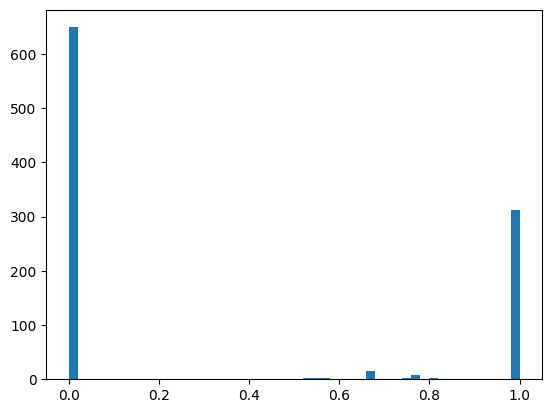

In [ ]:
plt.hist(scores, bins=50);

In [ ]:
np.mean(scores)

0.3383504014386889

In [ ]:
np.random.seed(1)

def print_random_translation():
  i = np.random.choice(len(eng_phrases_subset))
  eng = eng_phrases_subset[i]
  print("EN:", eng)

  translation = translations[i]['translation_text']
  print("ES Translation:", translation)

  matches = eng2spa[eng]
  print("Matches:", matches)

In [ ]:
print_random_translation()

EN: Tom isn't that young.
ES Translation: Tom no es tan joven.
Matches: ['Tom no es tan joven.']


In [ ]:
print_random_translation()

EN: Tom's Mary's brother.
ES Translation: Tom es el hermano de Mary.
Matches: ['Tom es el hermano de Mary.']


In [ ]:
print_random_translation()

EN: Can you describe them?
ES Translation: ¿Puede describirlos?
Matches: ['¿Podrías describirles?', '¿Podrías describirlos?']


### **Question Answering**

In [ ]:
qa = pipeline("question-answering")

No model was supplied, defaulted to distilbert-base-cased-distilled-squad and revision 626af31 (https://huggingface.co/distilbert-base-cased-distilled-squad).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [ ]:
context = "Today I went to the store to purchase a carton of milk."
question = "What did I buy?"

In [ ]:
qa(context=context, question=question)

{'score': 0.5626220107078552,
 'start': 38,
 'end': 54,
 'answer': 'a carton of milk'}

In [ ]:
context[38:54]

'a carton of milk'

In [ ]:
context = "Out of all the colors, I like blue the best."
question = "What is my favorite color?"
qa(context=context, question=question)

{'score': 0.9958469867706299, 'start': 30, 'end': 34, 'answer': 'blue'}

In [ ]:
context = "Albert Einstein (14 March 1879 – 18 April 1955) was a " + \
  "German-born theoretical physicist, widely acknowledged to be one of the " + \
  "greatest physicists of all time. Einstein is best known for developing " + \
  "the theory of relativity, but he also made important contributions to " + \
  "the development of the theory of quantum mechanics. Relativity and " + \
  "quantum mechanics are together the two pillars of modern physics."

In [ ]:
question = "When was Albert Einstein born?"
qa(context=context, question=question)

{'score': 0.951105535030365, 'start': 17, 'end': 30, 'answer': '14 March 1879'}

In [ ]:
question = "What was Albert Einstein's occupation?"
qa(context=context, question=question)

{'score': 0.9473747611045837,
 'start': 66,
 'end': 87,
 'answer': 'theoretical physicist'}

In [ ]:
question = "What is Albert Einstein best known for?"
qa(context=context, question=question)

{'score': 0.8471301198005676,
 'start': 186,
 'end': 221,
 'answer': 'developing the theory of relativity'}

In [ ]:
question = "What else has Albert Einstein contributed to?"
qa(context=context, question=question)

{'score': 0.28260570764541626,
 'start': 290,
 'end': 317,
 'answer': 'theory of quantum mechanics'}

In [ ]:
question = "What are the two pillars of modern physics?"
qa(context=context, question=question)

{'score': 0.9952630400657654,
 'start': 319,
 'end': 351,
 'answer': 'Relativity and quantum mechanics'}

In [ ]:
question = "Where was Albert Einstein born?"
qa(context=context, question=question)

{'score': 0.994666337966919, 'start': 54, 'end': 60, 'answer': 'German'}

In [ ]:
question = "What is peanut butter made of?"
qa(context=context, question=question)

{'score': 0.0024855495430529118,
 'start': 0,
 'end': 15,
 'answer': 'Albert Einstein'}

### **Zero-Shot Classification**

In [ ]:
# https://www.kaggle.com/shivamkushwaha/bbc-full-text-document-classification
!wget -nc https://lazyprogrammer.me/course_files/nlp/bbc_text_cls.csv

File ‘bbc_text_cls.csv’ already there; not retrieving.



In [ ]:
classifier = pipeline("zero-shot-classification", device=0)

No model was supplied, defaulted to facebook/bart-large-mnli and revision c626438 (https://huggingface.co/facebook/bart-large-mnli).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [ ]:
classifier("This is a great movie", candidate_labels=["positive", "negative"])

{'sequence': 'This is a great movie',
 'labels': ['positive', 'negative'],
 'scores': [0.9969461560249329, 0.0030538293067365885]}

In [ ]:
# https://en.wikipedia.org/wiki/AMP-activated_protein_kinase
text = "Due to the presence of isoforms of its components, there are 12 " + \
  "versions of AMPK in mammals, each of which can have different tissue " + \
  "localizations, and different functions under different conditions. " + \
  "AMPK is regulated allosterically and by post-translational " + \
  "modification, which work together."
classifier(text, candidate_labels=["biology", "math", "geology"])

{'sequence': 'Due to the presence of isoforms of its components, there are 12 versions of AMPK in mammals, each of which can have different tissue localizations, and different functions under different conditions. AMPK is regulated allosterically and by post-translational modification, which work together.',
 'labels': ['biology', 'math', 'geology'],
 'scores': [0.8908604383468628, 0.06606573611497879, 0.0430738590657711]}

In [ ]:
df = pd.read_csv('bbc_text_cls.csv')

In [ ]:
len(df)

2225

In [ ]:
df.sample(frac=1).head()

,text,labels
1045,Galloway plea for hostage release\n\nEx-Labour...,politics
1503,Tottenham bid &#163;8m for Forest duo\n\nNotti...,sport
834,Bening makes awards breakthrough\n\nFilm actre...,entertainment
791,Rap feud in 50 Cent's G-Unit crew\n\nUS rap st...,entertainment
428,US trade gap ballooned in October\n\nThe US tr...,business


In [ ]:
labels = list(set(df['labels']))
labels

['sport', 'business', 'politics', 'entertainment', 'tech']

In [ ]:
print(textwrap.fill(df.iloc[1024]['text']))

UK troops on Ivory Coast standby  Downing Street has confirmed British
troops are on standby in case they need to help evacuate several
hundred UK citizens from Ivory Coast.  The news came as it emerged
France had begun evacuating its hostages after days of anti-French
demonstrations. Trouble flared after nine French peacekeepers were
killed and President Jacques Chirac ordered the destruction of the
Ivory Coast's air force. A company of 100-120 UK troops is understood
to have been put on standby. They are ready to fly out and secure the
route from the embassy to the airport if called upon. Prime Minister
Tony Blair's official spokesman said: "There are British nationals in
Ivory Coast and as you can imagine we are making the usual contingency
plans in case the situation deteriorates further, but that's all I can
say at this stage."  He added the situation would be monitored
carefully in case evacuation became necessary. France has played a
lead role in international peacekeeping in Iv

In [ ]:
df.iloc[1024]['labels']

'politics'

In [ ]:
classifier(df.iloc[1024]['text'], candidate_labels=labels)

{'sequence': 'UK troops on Ivory Coast standby\n\nDowning Street has confirmed British troops are on standby in case they need to help evacuate several hundred UK citizens from Ivory Coast.\n\nThe news came as it emerged France had begun evacuating its hostages after days of anti-French demonstrations. Trouble flared after nine French peacekeepers were killed and President Jacques Chirac ordered the destruction of the Ivory Coast\'s air force. A company of 100-120 UK troops is understood to have been put on standby. They are ready to fly out and secure the route from the embassy to the airport if called upon. Prime Minister Tony Blair\'s official spokesman said: "There are British nationals in Ivory Coast and as you can imagine we are making the usual contingency plans in case the situation deteriorates further, but that\'s all I can say at this stage."\n\nHe added the situation would be monitored carefully in case evacuation became necessary. France has played a lead role in internati

In [ ]:
# Takes less than 55 min but long
preds = classifier(df['text'].tolist(), candidate_labels=labels)

In [ ]:
preds[0:5]

[{'sequence': 'Ad sales boost Time Warner profit\n\nQuarterly profits at US media giant TimeWarner jumped 76% to $1.13bn (£600m) for the three months to December, from $639m year-earlier.\n\nThe firm, which is now one of the biggest investors in Google, benefited from sales of high-speed internet connections and higher advert sales. TimeWarner said fourth quarter sales rose 2% to $11.1bn from $10.9bn. Its profits were buoyed by one-off gains which offset a profit dip at Warner Bros, and less users for AOL.\n\nTime Warner said on Friday that it now owns 8% of search-engine Google. But its own internet business, AOL, had has mixed fortunes. It lost 464,000 subscribers in the fourth quarter profits were lower than in the preceding three quarters. However, the company said AOL\'s underlying profit before exceptional items rose 8% on the back of stronger internet advertising revenues. It hopes to increase subscribers by offering the online service free to TimeWarner internet customers and w

In [ ]:
predicted_labels = [d['labels'][0] for d in preds]

In [ ]:
df['predicted_labels'] = predicted_labels

In [ ]:
print("Acc:", np.mean(df['predicted_labels'] == df['labels']))

Acc: 0.5649438202247191


In [ ]:
# Convert prediction probs into an NxK matrix according to
# original label order

N = len(df)
K = len(labels)
label2idx = {v:k for k,v in enumerate(labels)}

probs = np.zeros((N, K))
for i in range(N):
  # loop through labels and scores in corresponding order
  d = preds[i]
  for label, score in zip(d['labels'], d['scores']):
    k = label2idx[label]
    probs[i, k] = score

In [ ]:
int_labels = [label2idx[x] for x in df['labels']]

In [ ]:
int_preds = np.argmax(probs, axis=1)
cm = confusion_matrix(int_labels, int_preds, normalize='true')

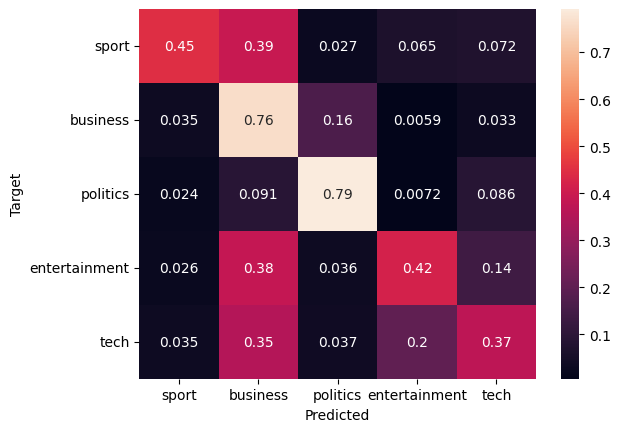

In [ ]:
# Scikit-Learn is transitioning to V1 but it's not available on Colab
# The changes modify how confusion matrices are plotted
def plot_cm(cm):
  df_cm = pd.DataFrame(cm, index=labels, columns=labels)
  ax = sn.heatmap(df_cm, annot=True, fmt='.2g')
  ax.set_xlabel("Predicted")
  ax.set_ylabel("Target")

plot_cm(cm)

In [ ]:
f1_score(df['labels'], predicted_labels, average='micro')

0.5649438202247191

In [ ]:
roc_auc_score(int_labels, probs, multi_class='ovo')

0.8853272009635841